# end-end machine learning project on California housing dataset.

for complete reference, refer to this notebook by Aurelion Geron

https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb

## EDA

### Download the Data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt

### Take a quick look at the data structure

In [2]:
def load_housing_data():
    return pd.read_csv(Path("datasets/housing.csv"))

In [3]:
housing = load_housing_data()

Take a Quick look at the Data Structure

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


information about all columns

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#### to see the number of categories in a categorical variable

In [6]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

#### Information about all numerical variables

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


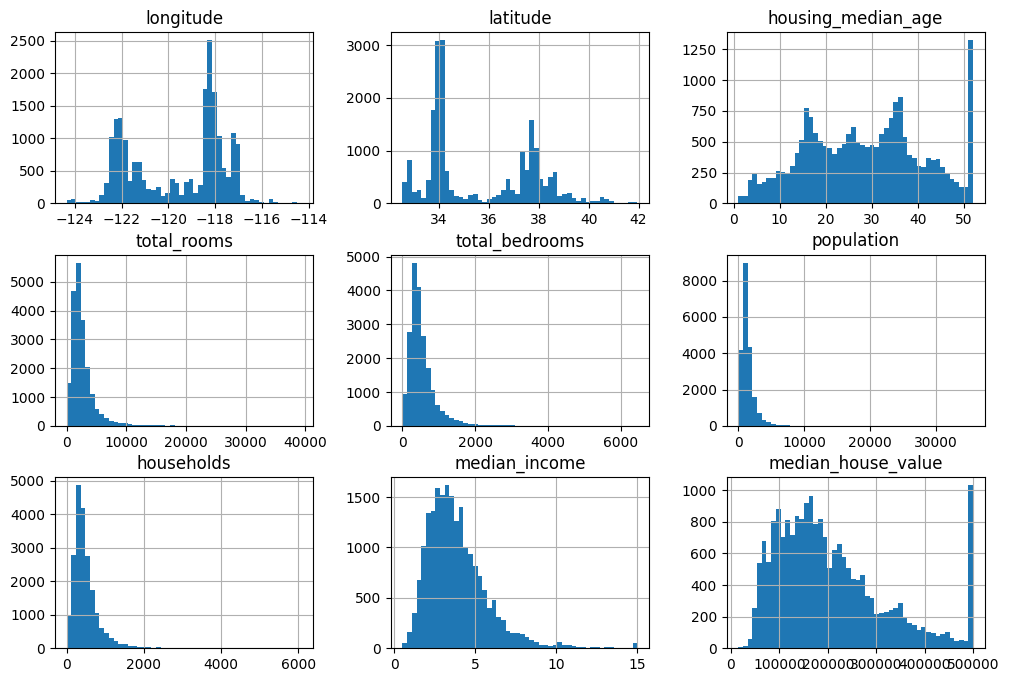

In [8]:
housing.hist(bins = 50, figsize = (12,8))  #binsize tells teh number of ranges defined 
plt.show()       

but, if the model is trained on the whole set, it gives an optimistic prediction on the test set. This is called data snoopoing
bias. In order to avoid it, a seperate test set must be created which should be unseed throughout the training process.

# Test set generation

## creating a test set method -1

In [9]:
import numpy as np

In [10]:
def shuffle_and_split_data(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


The method described above will ensure that the model doesnt see the test set during the training. This helps us understand how good the model can generalize.

## creating a test set method -2

method-1 cannot preserve the integrity of distribution when the data is updated. assuming data is always appended to the last, the follwoing method works.
it uses hashing to identify which indices will join the test set and which do not

In [12]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

#### create an identifier column for the housing dataset

In [13]:
housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, 'index')

## creating a test set method -3

In [14]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

Note that random sampling is great as long as the dataset has a large number of rows. Else, stratified sampling is to be done

Stratified Sampling:-
it ensures that the test sate is representative of all kinds of data.
the population is divided into homogenous groups called strata and the right numbner of instances are sampled from each stratum to guarantee that the test set is representative of the overall population.
This ensures that the random sampling doesnt have skewing.

### stratification based on median income

In [15]:
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels = [1,2,3,4,5])


in the code above, the income is divided into bins 4 bins of size 1.5 starting from 0, and all the other rightmost values into one bin. the frequency for each bin is shown.

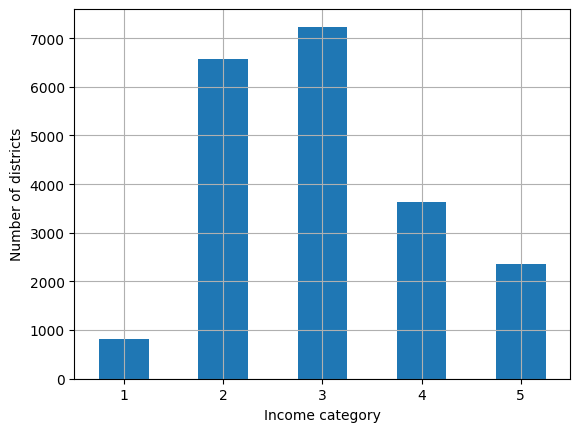

In [16]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

now the model is ready to have stratified sampling based on the income cateogry using scikit-learn

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
    


In [18]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size = 0.2, stratify = housing['income_cat'], random_state = 42) #stratified sampling

##  comparison of distributions in the three test sets generated

In [19]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42) #pure random sampling

test_set['income_cat'].value_counts()/len(test_set) #pure distribution of test set

income_cat
3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: count, dtype: float64

In [20]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set) #sratified disribution of test set

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [21]:
housing['income_cat'].value_counts()/len(housing) #original distribution of whole data

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

As seen by the distributions above, the category proportions generated by stratified sampling are much closer to that of the original dataset distribution as compared to the purely random sampling.
The category column is no longer needed and we can drop it now

In [22]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis = 1, inplace = True)


# Data visualization and exploration

exploring is done on the train set. if the train set is too large, put aside a small portion of it to make the mainpulations easy and fast. 
make a copy of the training set so that various transformations can be performed

## Visualizing geographical data


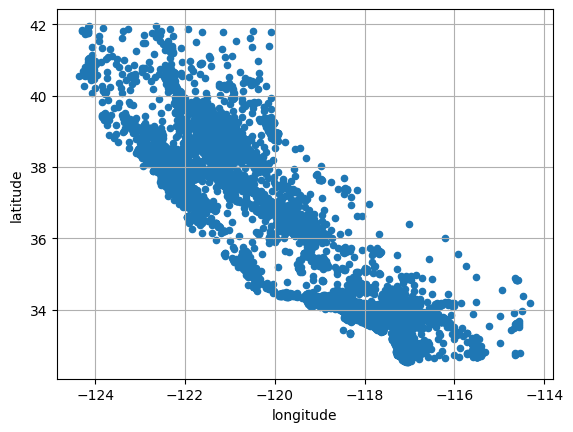

In [23]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True)
plt.show()

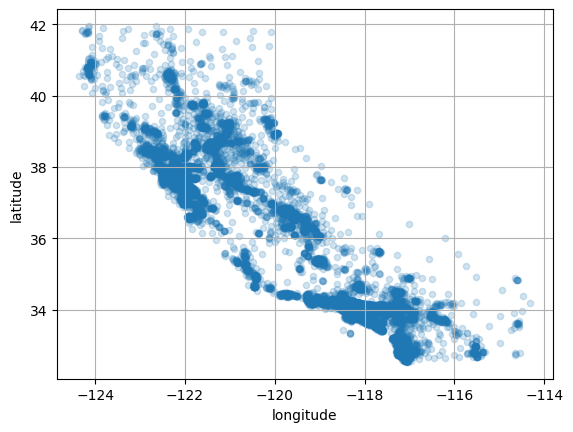

In [24]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True, alpha = 0.2)
plt.show()

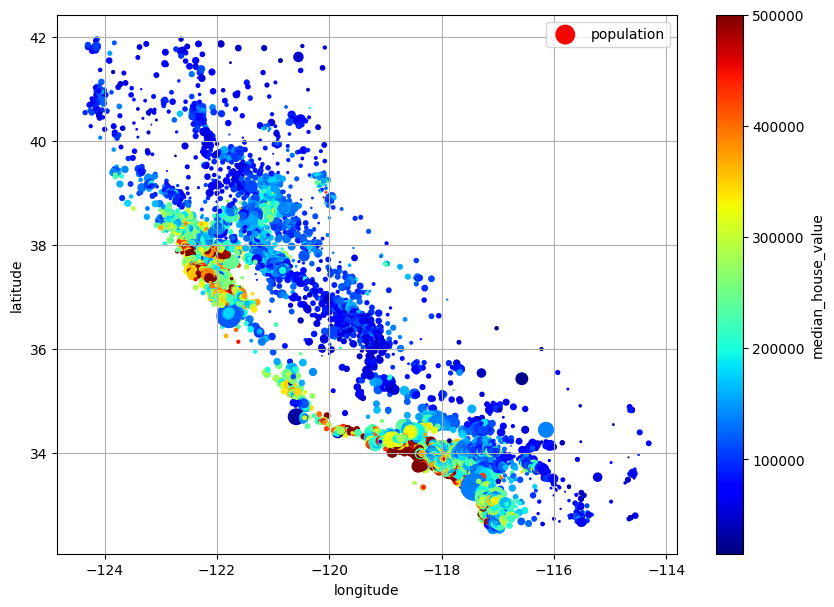

In [25]:
housing.plot(kind = 'scatter', x= 'longitude', y = 'latitude', grid = True,
            s= housing['population']/100, label = 'population',
            c = 'median_house_value', cmap = 'jet', colorbar = True,
            legend = True, sharex = False, figsize = (10,7))

plt.show()

## look for correlations


### drop the non-numeric field


In [26]:
housing_numeric = housing.copy()
housing_numeric.drop('ocean_proximity', axis =1, inplace = True)


pairwise correlation is found for each numeric column of the dataframe


In [27]:
corr_matrix = housing_numeric.corr()

In [28]:
for row in corr_matrix:
    print('\ncorrelation values for field:',row,'\n')
    print(corr_matrix[row].sort_values(ascending= False))
    


correlation values for field: longitude 

longitude             1.000000
population            0.099773
total_bedrooms        0.069608
households            0.055310
total_rooms           0.044568
income_cat           -0.010690
median_income        -0.015176
median_house_value   -0.045967
housing_median_age   -0.108197
latitude             -0.924664
Name: longitude, dtype: float64

correlation values for field: latitude 

latitude              1.000000
housing_median_age    0.011173
total_rooms          -0.036100
total_bedrooms       -0.066983
households           -0.071035
median_income        -0.079809
income_cat           -0.085528
population           -0.108785
median_house_value   -0.144160
longitude            -0.924664
Name: latitude, dtype: float64

correlation values for field: housing_median_age 

housing_median_age    1.000000
median_house_value    0.105623
latitude              0.011173
longitude            -0.108197
median_income        -0.119034
income_cat           -0.1

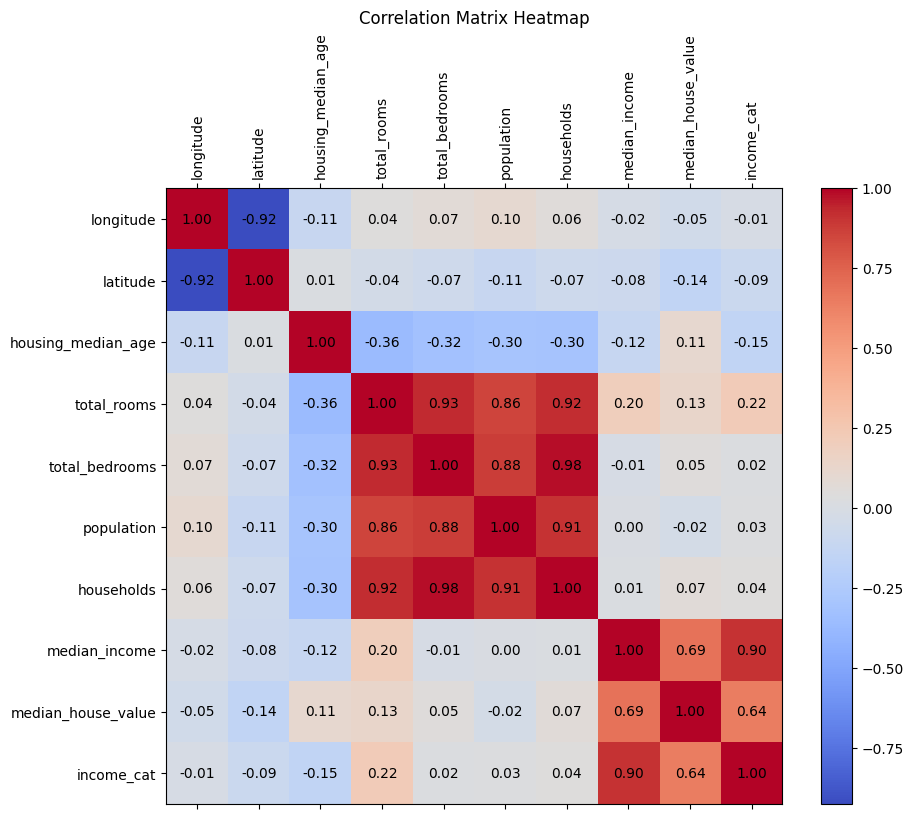

In [29]:
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a heatmap of the correlation matrix
cax = ax.matshow(corr_matrix, cmap='coolwarm')
fig.colorbar(cax)  # Add a colorbar to the right of the heatmap

# Set labels for the x and y axes
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Display the correlation values in each cell
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha='center', va='center', color='black')

# Set a title for the plot
ax.set_title('Correlation Matrix Heatmap')

# Show the plot
plt.show()


# preparing the data for machine learning


## clean the data


In [30]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


### analysis

the total_bedrooms column seems to have some null values. Machine learning algorithms cannot work with missing features. So, it has to be dealt with. three ways to fix this:-

1) get rid of the corresponding districts
2) get rid of the whole attribute
3) set the missinv values to some value( imputation)

### options exploration

In [31]:
housing_temp1 = housing.copy()
housing_temp2 = housing.copy()
housing_temp3 = housing.copy()

#### dropping the column

In [32]:
housing_temp1.dropna(subset = ['total_bedrooms'], inplace = True)
housing_temp1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20433 non-null  float64 
 1   latitude            20433 non-null  float64 
 2   housing_median_age  20433 non-null  float64 
 3   total_rooms         20433 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20433 non-null  float64 
 6   households          20433 non-null  float64 
 7   median_income       20433 non-null  float64 
 8   median_house_value  20433 non-null  float64 
 9   ocean_proximity     20433 non-null  object  
 10  income_cat          20433 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.7+ MB


#### dropping the whole attribute

In [33]:
housing_temp2 = housing_temp2.drop('total_bedrooms', axis = 1)
housing_temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   population          20640 non-null  float64 
 5   households          20640 non-null  float64 
 6   median_income       20640 non-null  float64 
 7   median_house_value  20640 non-null  float64 
 8   ocean_proximity     20640 non-null  object  
 9   income_cat          20640 non-null  category
dtypes: category(1), float64(8), object(1)
memory usage: 1.4+ MB


#### imputation

In [34]:
median_bedrooms = housing_temp3['total_bedrooms'].median()
housing_temp3['total_bedrooms'].fillna(median_bedrooms, inplace = True)
housing_temp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20640 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


### analysis

of the explored options, imputations seems to be the least destructive. So, it will be selected for further processinge

### imputation.

In [35]:
from sklearn.impute import SimpleImputer

#### create a simple imputer instance


In [36]:
imputer = SimpleImputer(strategy = 'median')

#### fit the imputer

In [37]:
housing_numeric = housing.select_dtypes(include = [np.number])

In [38]:
imputer.fit(housing_numeric)
housing_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


the imputer has calculated the median of each attribute and stored the result in its statistics_ variable. 

In [39]:
print(imputer.statistics_)
print(housing_numeric.median().values)

[-1.1849e+02  3.4260e+01  2.9000e+01  2.1270e+03  4.3500e+02  1.1660e+03
  4.0900e+02  3.5348e+00  1.7970e+05]
[-1.1849e+02  3.4260e+01  2.9000e+01  2.1270e+03  4.3500e+02  1.1660e+03
  4.0900e+02  3.5348e+00  1.7970e+05]


In [40]:
x = imputer.transform(housing_numeric)

In [41]:
housing_tr = pd.DataFrame(x, columns = housing_numeric.columns, index = housing_numeric.index)

In [42]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


## handling text and categorical attributes

text in categorical attributes can be converted into numbers. 

three ways to acheive this

1) ordinal encoding
2) one hot encoding
3) get dummies

### ordinal encoding

In [43]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder() # creating an instance

In [44]:
ocean_proximity = housing[['ocean_proximity']]
ocean_proximity_encoded = ordinal_encoder.fit_transform(ocean_proximity)

In [45]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

this approach of ordinal encoding assumes that two nearby values are more similar than two distant values

### one hot encoding


to fix the problems of ordinal encoding, one binary attribute is created for each category and one attribute is equal to 1 
when it is found.
the new attributes are caleld dummy attributes.
one hot encoder converts categorical values into one-hot vectors

In [46]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse = False) # by default a 'sparse matrix'(efficient) would be created. instead we want a numpy array
ocean_proximity_hot1 = encoder.fit_transform(ocean_proximity)

C:\Users\P N Charyulu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [47]:
ocean_proximity_hot1

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [48]:
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### get dummies

In [49]:
pd.get_dummies(ocean_proximity)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,False,True,False
3,False,False,False,True,False
4,False,False,False,True,False
...,...,...,...,...,...
20635,False,True,False,False,False
20636,False,True,False,False,False
20637,False,True,False,False,False
20638,False,True,False,False,False


### analysis

ordinal encoding is used where there is an inherent odering in some sense. 
one hot encoding and get_dummies are used where there is no inherent ordering among the categories.

The advantage of OneHotEncoder is that it remembers which categories it was trained on. It doesnt generate a column for unkonwn categories. Whereas get_dummies doesnt remember which categories it was trained on, and it generates columns for unknown categories  also.

also, OneHotEncoder can be tweaked to handle unkown categories by setting the 'handle_unknown' hyper parameter to 'ignore'.

one-hot encoding is not suitable when there are a large number of possible categories So, it is good to replace such categories with an appropriate numerical data or use the category encoders provided by sklearn.

when dealing with neural networks, you can replace each category with a learnable low-dimensional vector called embedding. This is an example of representation learning.